# Лабораторная работа 3. Свёрточные сети

#### Задание 1.
Построить свёрточную сеть LeNet-5 и обучить её распознаванию MNIST.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import time
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from collections import OrderedDict

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
batch_size = 100
input_size = 28 * 28
num_classes = 10
num_epochs = 15
learning_rate = 0.0001
total_step = 600
best = 0

In [7]:
train_loader =torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [8]:
class LeNet5_default(nn.Module):

    def __init__(self, num_of_classes):
        super(LeNet5_default, self).__init__()
        
        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)),
            ('tanh1', nn.Tanh()),
            ('aver_pool1', nn.AvgPool2d(kernel_size=2)),
            ('conv2', nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
            ('tanh2', nn.Tanh()),
            ('aver_pool2', nn.AvgPool2d(kernel_size=2)),
            ('conv3', nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1)),
            ('tanh3', nn.Tanh()),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(in_features=120, out_features=84)),
            ('tanh_linear', nn.Tanh()),
            ('output', nn.Linear(in_features=84, out_features=num_of_classes)),
        ]))


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [57]:
def init_weights(m):
    if type(m) == nn.Linear:                       
        torch.nn.init.kaiming_normal_(m.weight, a=0,
            mode='fan_in', nonlinearity='leaky_relu')        
        m.bias.data.fill_(0)

At model - None ; Accuracy = 98.42

With paramentres: Hidden_size = 1000, Epoch  = 9, Optimizer = Adam

Weight decay = False, init type for weights = Xavier

In [58]:
def train(model, num_epochs, graph, steps):
    loss_list = []
    start_time = time()
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            images = images.to(device)                
            labels = labels.to(device)

            outputs = model(images)        
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                if steps == True:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
                loss_list.append(loss.item())
    
    if steps == False:
        print(f'Final loss = {loss_list[-1]:.4f}')
        
    print(f'Time = {time() - start_time:.1f} sec')    
    
    
    if graph == True:
        steps = np.linspace(0, num_epochs*total_step, num = int(num_epochs*total_step/100))
        plt.plot(steps, loss_list)

        plt.xlabel('steps')
        plt.ylabel('loss')
        plt.show()

Epoch [1/15], Step [100/600], Loss: 1.4549
Epoch [1/15], Step [200/600], Loss: 0.7490
Epoch [1/15], Step [300/600], Loss: 0.6321
Epoch [1/15], Step [400/600], Loss: 0.5408
Epoch [1/15], Step [500/600], Loss: 0.4967
Epoch [1/15], Step [600/600], Loss: 0.4841
Epoch [2/15], Step [100/600], Loss: 0.5048
Epoch [2/15], Step [200/600], Loss: 0.3951
Epoch [2/15], Step [300/600], Loss: 0.2119
Epoch [2/15], Step [400/600], Loss: 0.4215
Epoch [2/15], Step [500/600], Loss: 0.3958
Epoch [2/15], Step [600/600], Loss: 0.2967
Epoch [3/15], Step [100/600], Loss: 0.3528
Epoch [3/15], Step [200/600], Loss: 0.4547
Epoch [3/15], Step [300/600], Loss: 0.3944
Epoch [3/15], Step [400/600], Loss: 0.2236
Epoch [3/15], Step [500/600], Loss: 0.1848
Epoch [3/15], Step [600/600], Loss: 0.1616
Epoch [4/15], Step [100/600], Loss: 0.1897
Epoch [4/15], Step [200/600], Loss: 0.2316
Epoch [4/15], Step [300/600], Loss: 0.1917
Epoch [4/15], Step [400/600], Loss: 0.2317
Epoch [4/15], Step [500/600], Loss: 0.2806
Epoch [4/15

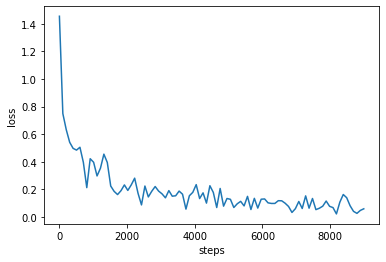

In [35]:
loss_fn = nn.CrossEntropyLoss()
model = LeNet5_default(num_of_classes=num_classes)
model.to(device)
loss_list = train(model, num_epochs, True, True)

In [59]:
def Accuracy_value(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            max_values, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct/total

In [37]:
print(Accuracy_value(model))

97.98


#### Задание 2.
Поэкспериментировать с параметрами LeNet-5 и найти оптимальную архитектуру для MNIST.  

Параметры для подбора:
- количество свёрточных слоев
- функция активации (Tanh, ReLU)
- способ субдискретизации (Average, Max)
- размер фильтров
- количество фильтров

In [64]:
num_epochs = 2
loss_fn = nn.CrossEntropyLoss()

In [50]:
def feature_extraction(
    number_layer, out, kernel_size, 
    activation, pool, ks_pool, pool_struct, d):
    d['conv' + str(number_layer)] = nn.Conv2d(
        in_channels = out[number_layer - 1], out_channels = out[number_layer],
        kernel_size = kernel_size[number_layer]
    )
    d['tanh' + str(number_layer)] = activation
    if pool_struct[number_layer] == 1:
        d['aver_pool' + str(number_layer)] = pool(kernel_size = ks_pool)

In [66]:
class LeNet5_test(nn.Module):
    def __init__(self, n_classes, out, kernel_size, activation, 
                 pool, kernel_size_pool, pool_struct                                 
                ):
        super(LeNet5_test, self).__init__()
        
        Ordered_dict = OrderedDict()
        Ordered_dict['conv0'] = nn.Conv2d(
                in_channels=1, out_channels=out[0], 
                kernel_size=kernel_size[0])
        Ordered_dict['tanh0'] = activation
        if pool_struct[0] == 1:
            Ordered_dict['aver_pool0'] = pool(kernel_size = kernel_size_pool)
        
        for i in range(1, len(out)):
            feature_extraction(i, out, kernel_size, 
                      activation, pool, kernel_size_pool,
                      pool_struct, Ordered_dict)
        
        self.feature_extractor = nn.Sequential(Ordered_dict)

        self.classifier = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(in_features=out[2], out_features=84)),
            ('tanh_linear', nn.Tanh()),
            ('output', nn.Linear(in_features=84, out_features=n_classes)),
        ]))
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)     
        return logits     

In [71]:
num_epochs = 2

out = [
    [6, 16, 120],
    [16, 120, 280],
    [160, 480, 860]
]
activation = [nn.ReLU(), nn.Tanh()]
pool = [nn.MaxPool2d, nn.AvgPool2d]
kernel_size = [
    [5, 5, 4],
    [3, 5, 4]
]
stride = [
    [1, 1, 1],
]
pool_struct = [
    [1, 1, 0]
]
kernel_size_pool = 2

out_best = []
kernel_best = []
stride_best = []
activation_best = []
kernel_size_best = 0
pool_best = []
upd = 0
Accuracy = 0
Accuracy_chek = 0

for o in out:
    for ks in kernel_size:
        for ps in pool_struct:
            for s in stride:
                for a in activation:
                    for p in pool:                
                        model = LeNet5_test(
                            n_classes = num_classes, out = o, kernel_size = ks, 
                            activation = a, stride = s, pool = p, 
                            kernel_size_pool = kernel_size_pool, pool_struct = ps)
                        model.to(device)
                        print(model)
                        train(model, num_epochs, False, False)
                        Accuracy_chek = Accuracy_value(model)
                        print()
                        if(Accuracy < Accuracy_chek):
                            Accuracy = Accuracy_chek
                            out_best.append(o)
                            kernel_best.append(ks)
                            stride_best.append(s)
                            activation_best.append(a)
                            pool_best.append(p)

                            print("Update value of best Accuracy")
                            print(f"Up Accuracy to {Accuracy} with structure:")
                            print(f"Out struct = \t{out_best[upd]}\t kernel size = \t{kernel_best[upd]}")
                            print(f"Stride value = \t{stride_best[upd]}\t activation func = \t{activation_best[upd]}")
                            print(f"Pool = {pool_best[upd]}") 
                            upd += 1

                        print()

LeNet5_test(
  (feature_extractor): Sequential(
    (conv0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (tanh0): ReLU()
    (aver_pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (tanh1): ReLU()
    (aver_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (tanh2): ReLU()
  )
  (classifier): Sequential(
    (linear): Linear(in_features=120, out_features=84, bias=True)
    (tanh_linear): Tanh()
    (output): Linear(in_features=84, out_features=10, bias=True)
  )
)
Final loss = 0.1635
Time = 10.6 sec

Update value of best Accuracy
Up Accuracy to 93.61 with structure:
Out struct = 	[6, 16, 120]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

LeNet5_test(
  (feature_extractor): Sequential(
    (conv0): 

)
Final loss = 0.0513
Time = 17.1 sec

Update value of best Accuracy
Up Accuracy to 98.17 with structure:
Out struct = 	[16, 120, 280]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	Tanh()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

LeNet5_test(
  (feature_extractor): Sequential(
    (conv0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (tanh0): Tanh()
    (aver_pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (tanh1): Tanh()
    (aver_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv2): Conv2d(120, 280, kernel_size=(4, 4), stride=(1, 1))
    (tanh2): Tanh()
  )
  (classifier): Sequential(
    (linear): Linear(in_features=280, out_features=84, bias=True)
    (tanh_linear): Tanh()
    (output): Linear(in_features=84, out_features=10, bias=True)
  )
)
Final loss = 0.2200
Time = 17.7 sec


LeNet5_test(
  (feature_extractor): Sequential(
    (conv0): Conv2d(1, 16

)
Final loss = 0.0375
Time = 151.0 sec


LeNet5_test(
  (feature_extractor): Sequential(
    (conv0): Conv2d(1, 160, kernel_size=(3, 3), stride=(1, 1))
    (tanh0): Tanh()
    (aver_pool0): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): Conv2d(160, 480, kernel_size=(5, 5), stride=(1, 1))
    (tanh1): Tanh()
    (aver_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv2): Conv2d(480, 860, kernel_size=(4, 4), stride=(1, 1))
    (tanh2): Tanh()
  )
  (classifier): Sequential(
    (linear): Linear(in_features=860, out_features=84, bias=True)
    (tanh_linear): Tanh()
    (output): Linear(in_features=84, out_features=10, bias=True)
  )
)
Final loss = 0.0583
Time = 153.4 sec




In [73]:
print("Update value of best Accuracy")
print(f"Up Accuracy to {Accuracy} with structure:")
print(f"Out struct = \t{out_best[upd]}\t kernel size = \t{kernel_best[upd]}")
print(f"Stride value = \t{stride_best[upd]}\t activation func = \t{activation_best[upd]}")
print(f"Pool = {pool_best[upd]}") 

Update value of best Accuracy
Up Accuracy to 98.94 with structure:
Out struct = 	[160, 480, 860]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>


In [39]:
class LeNet5(nn.Module):
    def __init__(self, n_classes, out,
                 kernel_size, activation, 
                 stride, pool, kernel_size_pool):
        super(LeNet5, self).__init__()
          
        self.feature_extractor = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(
                in_channels=1, out_channels=out[0], 
                kernel_size=kernel_size[0], stride=stride[0])),
            ('tanh1', activation),
            ('aver_pool1', pool(kernel_size=kernel_size_pool)),

            ('conv2', nn.Conv2d(
                in_channels=out[0], out_channels=out[1],
                kernel_size=kernel_size[1], stride=stride[1])),
            ('tanh2', activation),
            ('aver_pool2', pool(kernel_size=kernel_size_pool)),

            ('conv3', nn.Conv2d(
                in_channels=out[1], out_channels=out[2], 
                kernel_size=kernel_size[2], stride=stride[2])),
            ('tanh3', activation),
        ]))

        self.classifier = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(in_features=out[2], out_features=84)),
            ('tanh_linear', nn.Tanh()),
            ('output', nn.Linear(in_features=84, out_features=n_classes)),
        ]))
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)     
        return logits     

In [ ]:
out = [
    [6, 16, 120],
    [16, 120, 280],
    [160, 480, 860]
]
activation = [nn.ReLU(), nn.Tanh()]
pool = [nn.MaxPool2d, nn.AvgPool2d]
kernel_size = [
    [5, 5, 4],
    [3, 5, 4],
    [3, 3, 4]
]
stride = [
    [1, 1, 1],
    [2, 2, 2],
]
kernel_size_pool = 2

out_best = []
kernel_best = []
stride_best = []
activation_best = []
kernel_size_best = 0
pool_best = []
upd = 0
Accuracy = 0
Accuracy_chek = 0

Epoch [1/15], Step [100/600], Loss: 1.9869
Epoch [1/15], Step [200/600], Loss: 1.1595
Epoch [1/15], Step [300/600], Loss: 0.5780
Epoch [1/15], Step [400/600], Loss: 0.4451
Epoch [1/15], Step [500/600], Loss: 0.2894
Epoch [1/15], Step [600/600], Loss: 0.3461
Epoch [2/15], Step [100/600], Loss: 0.3129
Epoch [2/15], Step [200/600], Loss: 0.1737
Epoch [2/15], Step [300/600], Loss: 0.2027
Epoch [2/15], Step [400/600], Loss: 0.2440
Epoch [2/15], Step [500/600], Loss: 0.2411
Epoch [2/15], Step [600/600], Loss: 0.1922
Epoch [3/15], Step [100/600], Loss: 0.1885
Epoch [3/15], Step [200/600], Loss: 0.1720
Epoch [3/15], Step [300/600], Loss: 0.1913
Epoch [3/15], Step [400/600], Loss: 0.1293
Epoch [3/15], Step [500/600], Loss: 0.1033
Epoch [3/15], Step [600/600], Loss: 0.0787
Epoch [4/15], Step [100/600], Loss: 0.1067
Epoch [4/15], Step [200/600], Loss: 0.0728
Epoch [4/15], Step [300/600], Loss: 0.2551
Epoch [4/15], Step [400/600], Loss: 0.1106
Epoch [4/15], Step [500/600], Loss: 0.1623
Epoch [4/15

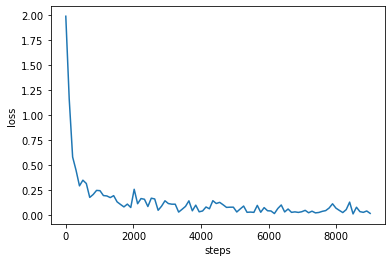


Update value of best Accuracy
Up Accuracy to 98.66 with structure:
Out struct = 	[6, 16, 120]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

Epoch [1/15], Step [100/600], Loss: 1.9043
Epoch [1/15], Step [200/600], Loss: 0.9456
Epoch [1/15], Step [300/600], Loss: 0.6354
Epoch [1/15], Step [400/600], Loss: 0.4637
Epoch [1/15], Step [500/600], Loss: 0.4997
Epoch [1/15], Step [600/600], Loss: 0.3824
Epoch [2/15], Step [100/600], Loss: 0.5299
Epoch [2/15], Step [200/600], Loss: 0.3583
Epoch [2/15], Step [300/600], Loss: 0.3236
Epoch [2/15], Step [400/600], Loss: 0.3240
Epoch [2/15], Step [500/600], Loss: 0.3274
Epoch [2/15], Step [600/600], Loss: 0.1948
Epoch [3/15], Step [100/600], Loss: 0.2695
Epoch [3/15], Step [200/600], Loss: 0.1793
Epoch [3/15], Step [300/600], Loss: 0.2545
Epoch [3/15], Step [400/600], Loss: 0.2361
Epoch [3/15], Step [500/600], Loss: 0.3391
Epoch [3/15], Step [600/600], Loss: 0.2634

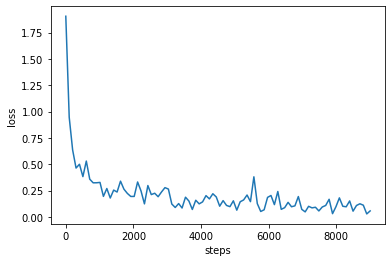



Epoch [1/15], Step [100/600], Loss: 1.7440
Epoch [1/15], Step [200/600], Loss: 0.8167
Epoch [1/15], Step [300/600], Loss: 0.5506
Epoch [1/15], Step [400/600], Loss: 0.3637
Epoch [1/15], Step [500/600], Loss: 0.3415
Epoch [1/15], Step [600/600], Loss: 0.3502
Epoch [2/15], Step [100/600], Loss: 0.2903
Epoch [2/15], Step [200/600], Loss: 0.2621
Epoch [2/15], Step [300/600], Loss: 0.2752
Epoch [2/15], Step [400/600], Loss: 0.1889
Epoch [2/15], Step [500/600], Loss: 0.2041
Epoch [2/15], Step [600/600], Loss: 0.2212
Epoch [3/15], Step [100/600], Loss: 0.2035
Epoch [3/15], Step [200/600], Loss: 0.1463
Epoch [3/15], Step [300/600], Loss: 0.1820
Epoch [3/15], Step [400/600], Loss: 0.1324
Epoch [3/15], Step [500/600], Loss: 0.1420
Epoch [3/15], Step [600/600], Loss: 0.2148
Epoch [4/15], Step [100/600], Loss: 0.1331
Epoch [4/15], Step [200/600], Loss: 0.0809
Epoch [4/15], Step [300/600], Loss: 0.1177
Epoch [4/15], Step [400/600], Loss: 0.0677
Epoch [4/15], Step [500/600], Loss: 0.1617
Epoch [4/

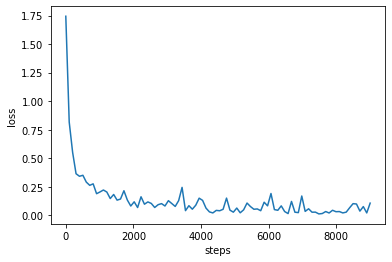



Epoch [1/15], Step [100/600], Loss: 1.4613
Epoch [1/15], Step [200/600], Loss: 0.8428
Epoch [1/15], Step [300/600], Loss: 0.6076
Epoch [1/15], Step [400/600], Loss: 0.4948
Epoch [1/15], Step [500/600], Loss: 0.5097
Epoch [1/15], Step [600/600], Loss: 0.3950
Epoch [2/15], Step [100/600], Loss: 0.5017
Epoch [2/15], Step [200/600], Loss: 0.4053
Epoch [2/15], Step [300/600], Loss: 0.2945
Epoch [2/15], Step [400/600], Loss: 0.4208
Epoch [2/15], Step [500/600], Loss: 0.4340
Epoch [2/15], Step [600/600], Loss: 0.2956
Epoch [3/15], Step [100/600], Loss: 0.3428
Epoch [3/15], Step [200/600], Loss: 0.2680
Epoch [3/15], Step [300/600], Loss: 0.2050
Epoch [3/15], Step [400/600], Loss: 0.3363
Epoch [3/15], Step [500/600], Loss: 0.3300
Epoch [3/15], Step [600/600], Loss: 0.4276
Epoch [4/15], Step [100/600], Loss: 0.2567
Epoch [4/15], Step [200/600], Loss: 0.1361
Epoch [4/15], Step [300/600], Loss: 0.2946
Epoch [4/15], Step [400/600], Loss: 0.1799
Epoch [4/15], Step [500/600], Loss: 0.1416
Epoch [4/

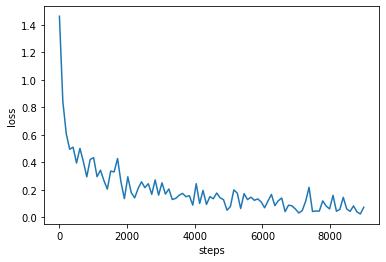



Epoch [1/15], Step [100/600], Loss: 1.9963
Epoch [1/15], Step [200/600], Loss: 1.3199
Epoch [1/15], Step [300/600], Loss: 0.7217
Epoch [1/15], Step [400/600], Loss: 0.6391
Epoch [1/15], Step [500/600], Loss: 0.5527
Epoch [1/15], Step [600/600], Loss: 0.4053
Epoch [2/15], Step [100/600], Loss: 0.2329
Epoch [2/15], Step [200/600], Loss: 0.2612
Epoch [2/15], Step [300/600], Loss: 0.1794
Epoch [2/15], Step [400/600], Loss: 0.2543
Epoch [2/15], Step [500/600], Loss: 0.2779
Epoch [2/15], Step [600/600], Loss: 0.1393
Epoch [3/15], Step [100/600], Loss: 0.1366
Epoch [3/15], Step [200/600], Loss: 0.3255
Epoch [3/15], Step [300/600], Loss: 0.1296
Epoch [3/15], Step [400/600], Loss: 0.1863
Epoch [3/15], Step [500/600], Loss: 0.2643
Epoch [3/15], Step [600/600], Loss: 0.2470
Epoch [4/15], Step [100/600], Loss: 0.1493
Epoch [4/15], Step [200/600], Loss: 0.1463
Epoch [4/15], Step [300/600], Loss: 0.1573
Epoch [4/15], Step [400/600], Loss: 0.1444
Epoch [4/15], Step [500/600], Loss: 0.1030
Epoch [4/

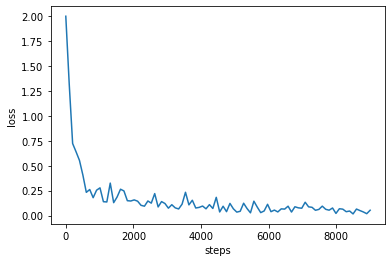



Epoch [1/15], Step [100/600], Loss: 2.0001
Epoch [1/15], Step [200/600], Loss: 1.1795
Epoch [1/15], Step [300/600], Loss: 0.7010
Epoch [1/15], Step [400/600], Loss: 0.6678
Epoch [1/15], Step [500/600], Loss: 0.4106
Epoch [1/15], Step [600/600], Loss: 0.4515
Epoch [2/15], Step [100/600], Loss: 0.3931
Epoch [2/15], Step [200/600], Loss: 0.4364
Epoch [2/15], Step [300/600], Loss: 0.3560
Epoch [2/15], Step [400/600], Loss: 0.3376
Epoch [2/15], Step [500/600], Loss: 0.3728
Epoch [2/15], Step [600/600], Loss: 0.1932
Epoch [3/15], Step [100/600], Loss: 0.2840
Epoch [3/15], Step [200/600], Loss: 0.3564
Epoch [3/15], Step [300/600], Loss: 0.2467
Epoch [3/15], Step [400/600], Loss: 0.1663
Epoch [3/15], Step [500/600], Loss: 0.3895
Epoch [3/15], Step [600/600], Loss: 0.2324
Epoch [4/15], Step [100/600], Loss: 0.3201
Epoch [4/15], Step [200/600], Loss: 0.2225
Epoch [4/15], Step [300/600], Loss: 0.3288
Epoch [4/15], Step [400/600], Loss: 0.1241
Epoch [4/15], Step [500/600], Loss: 0.3054
Epoch [4/

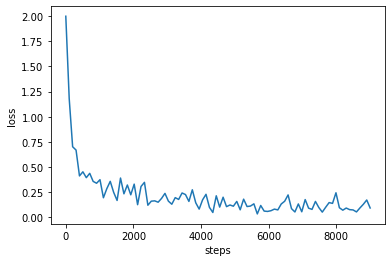



Epoch [1/15], Step [100/600], Loss: 1.7597
Epoch [1/15], Step [200/600], Loss: 0.9464
Epoch [1/15], Step [300/600], Loss: 0.5539
Epoch [1/15], Step [400/600], Loss: 0.3977
Epoch [1/15], Step [500/600], Loss: 0.3756
Epoch [1/15], Step [600/600], Loss: 0.2887
Epoch [2/15], Step [100/600], Loss: 0.3129
Epoch [2/15], Step [200/600], Loss: 0.2599
Epoch [2/15], Step [300/600], Loss: 0.4035
Epoch [2/15], Step [400/600], Loss: 0.2539
Epoch [2/15], Step [500/600], Loss: 0.1883
Epoch [2/15], Step [600/600], Loss: 0.1616
Epoch [3/15], Step [100/600], Loss: 0.2477
Epoch [3/15], Step [200/600], Loss: 0.1347
Epoch [3/15], Step [300/600], Loss: 0.1255
Epoch [3/15], Step [400/600], Loss: 0.1880
Epoch [3/15], Step [500/600], Loss: 0.1584
Epoch [3/15], Step [600/600], Loss: 0.1783
Epoch [4/15], Step [100/600], Loss: 0.1144
Epoch [4/15], Step [200/600], Loss: 0.2197
Epoch [4/15], Step [300/600], Loss: 0.1533
Epoch [4/15], Step [400/600], Loss: 0.1139
Epoch [4/15], Step [500/600], Loss: 0.0848
Epoch [4/

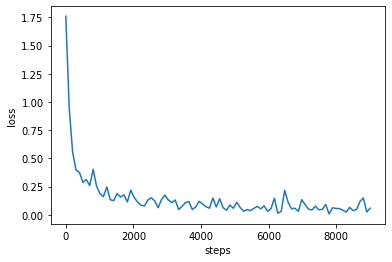



Epoch [1/15], Step [100/600], Loss: 1.6331
Epoch [1/15], Step [200/600], Loss: 0.9306
Epoch [1/15], Step [300/600], Loss: 0.6463
Epoch [1/15], Step [400/600], Loss: 0.5290
Epoch [1/15], Step [500/600], Loss: 0.4033
Epoch [1/15], Step [600/600], Loss: 0.4797
Epoch [2/15], Step [100/600], Loss: 0.3670
Epoch [2/15], Step [200/600], Loss: 0.4120
Epoch [2/15], Step [300/600], Loss: 0.3273
Epoch [2/15], Step [400/600], Loss: 0.4026
Epoch [2/15], Step [500/600], Loss: 0.3091
Epoch [2/15], Step [600/600], Loss: 0.3535
Epoch [3/15], Step [100/600], Loss: 0.3282
Epoch [3/15], Step [200/600], Loss: 0.4700
Epoch [3/15], Step [300/600], Loss: 0.1910
Epoch [3/15], Step [400/600], Loss: 0.2750
Epoch [3/15], Step [500/600], Loss: 0.4412
Epoch [3/15], Step [600/600], Loss: 0.3050
Epoch [4/15], Step [100/600], Loss: 0.2294
Epoch [4/15], Step [200/600], Loss: 0.2972
Epoch [4/15], Step [300/600], Loss: 0.3112
Epoch [4/15], Step [400/600], Loss: 0.3913
Epoch [4/15], Step [500/600], Loss: 0.3171
Epoch [4/

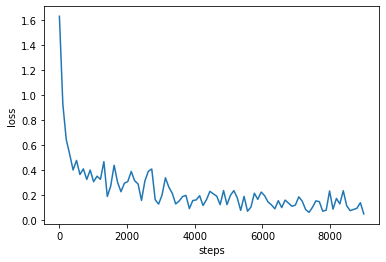



Epoch [1/15], Step [100/600], Loss: 0.6093
Epoch [1/15], Step [200/600], Loss: 0.3177
Epoch [1/15], Step [300/600], Loss: 0.1752
Epoch [1/15], Step [400/600], Loss: 0.1452
Epoch [1/15], Step [500/600], Loss: 0.1349
Epoch [1/15], Step [600/600], Loss: 0.1103
Epoch [2/15], Step [100/600], Loss: 0.1630
Epoch [2/15], Step [200/600], Loss: 0.1431
Epoch [2/15], Step [300/600], Loss: 0.2043
Epoch [2/15], Step [400/600], Loss: 0.0572
Epoch [2/15], Step [500/600], Loss: 0.0552
Epoch [2/15], Step [600/600], Loss: 0.1523
Epoch [3/15], Step [100/600], Loss: 0.0954
Epoch [3/15], Step [200/600], Loss: 0.0319
Epoch [3/15], Step [300/600], Loss: 0.1099
Epoch [3/15], Step [400/600], Loss: 0.1008
Epoch [3/15], Step [500/600], Loss: 0.0858
Epoch [3/15], Step [600/600], Loss: 0.0717
Epoch [4/15], Step [100/600], Loss: 0.0270
Epoch [4/15], Step [200/600], Loss: 0.0363
Epoch [4/15], Step [300/600], Loss: 0.0666
Epoch [4/15], Step [400/600], Loss: 0.0192
Epoch [4/15], Step [500/600], Loss: 0.0413
Epoch [4/

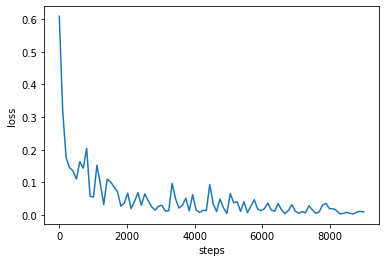


Update value of best Accuracy
Up Accuracy to 99.14 with structure:
Out struct = 	[16, 120, 280]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

Epoch [1/15], Step [100/600], Loss: 0.6496
Epoch [1/15], Step [200/600], Loss: 0.3745
Epoch [1/15], Step [300/600], Loss: 0.3201
Epoch [1/15], Step [400/600], Loss: 0.4508
Epoch [1/15], Step [500/600], Loss: 0.2587
Epoch [1/15], Step [600/600], Loss: 0.3023
Epoch [2/15], Step [100/600], Loss: 0.2023
Epoch [2/15], Step [200/600], Loss: 0.2172
Epoch [2/15], Step [300/600], Loss: 0.1080
Epoch [2/15], Step [400/600], Loss: 0.1701
Epoch [2/15], Step [500/600], Loss: 0.1196
Epoch [2/15], Step [600/600], Loss: 0.1579
Epoch [3/15], Step [100/600], Loss: 0.0768
Epoch [3/15], Step [200/600], Loss: 0.1040
Epoch [3/15], Step [300/600], Loss: 0.0699
Epoch [3/15], Step [400/600], Loss: 0.0960
Epoch [3/15], Step [500/600], Loss: 0.2198
Epoch [3/15], Step [600/600], Loss: 0.14

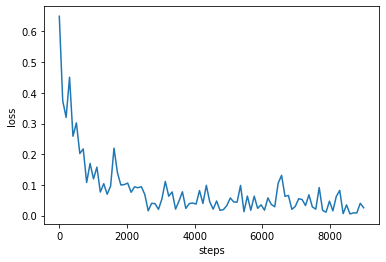



Epoch [1/15], Step [100/600], Loss: 0.4075
Epoch [1/15], Step [200/600], Loss: 0.2536
Epoch [1/15], Step [300/600], Loss: 0.1867
Epoch [1/15], Step [400/600], Loss: 0.1783
Epoch [1/15], Step [500/600], Loss: 0.1329
Epoch [1/15], Step [600/600], Loss: 0.1111
Epoch [2/15], Step [100/600], Loss: 0.0748
Epoch [2/15], Step [200/600], Loss: 0.1327
Epoch [2/15], Step [300/600], Loss: 0.1284
Epoch [2/15], Step [400/600], Loss: 0.0908
Epoch [2/15], Step [500/600], Loss: 0.0672
Epoch [2/15], Step [600/600], Loss: 0.0689
Epoch [3/15], Step [100/600], Loss: 0.0471
Epoch [3/15], Step [200/600], Loss: 0.0585
Epoch [3/15], Step [300/600], Loss: 0.0854
Epoch [3/15], Step [400/600], Loss: 0.0685
Epoch [3/15], Step [500/600], Loss: 0.0869
Epoch [3/15], Step [600/600], Loss: 0.0651
Epoch [4/15], Step [100/600], Loss: 0.0602
Epoch [4/15], Step [200/600], Loss: 0.0732
Epoch [4/15], Step [300/600], Loss: 0.0513
Epoch [4/15], Step [400/600], Loss: 0.0504
Epoch [4/15], Step [500/600], Loss: 0.0558
Epoch [4/

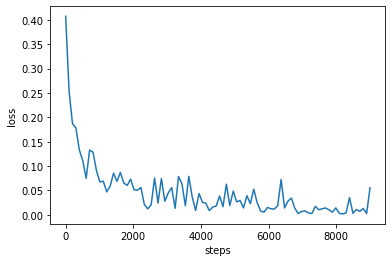



Epoch [1/15], Step [100/600], Loss: 0.4306
Epoch [1/15], Step [200/600], Loss: 0.3782
Epoch [1/15], Step [300/600], Loss: 0.4419
Epoch [1/15], Step [400/600], Loss: 0.3076
Epoch [1/15], Step [500/600], Loss: 0.2270
Epoch [1/15], Step [600/600], Loss: 0.1826
Epoch [2/15], Step [100/600], Loss: 0.1831
Epoch [2/15], Step [200/600], Loss: 0.2436
Epoch [2/15], Step [300/600], Loss: 0.2699
Epoch [2/15], Step [400/600], Loss: 0.2341
Epoch [2/15], Step [500/600], Loss: 0.3067
Epoch [2/15], Step [600/600], Loss: 0.1465
Epoch [3/15], Step [100/600], Loss: 0.0975
Epoch [3/15], Step [200/600], Loss: 0.2153
Epoch [3/15], Step [300/600], Loss: 0.1465
Epoch [3/15], Step [400/600], Loss: 0.1238
Epoch [3/15], Step [500/600], Loss: 0.1774
Epoch [3/15], Step [600/600], Loss: 0.1509
Epoch [4/15], Step [100/600], Loss: 0.2018
Epoch [4/15], Step [200/600], Loss: 0.2237
Epoch [4/15], Step [300/600], Loss: 0.1100
Epoch [4/15], Step [400/600], Loss: 0.1062
Epoch [4/15], Step [500/600], Loss: 0.1018
Epoch [4/

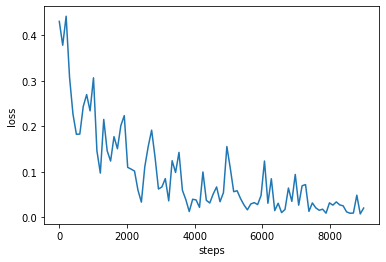



Epoch [1/15], Step [100/600], Loss: 0.5811
Epoch [1/15], Step [200/600], Loss: 0.3674
Epoch [1/15], Step [300/600], Loss: 0.3151
Epoch [1/15], Step [400/600], Loss: 0.1295
Epoch [1/15], Step [500/600], Loss: 0.2616
Epoch [1/15], Step [600/600], Loss: 0.1228
Epoch [2/15], Step [100/600], Loss: 0.1496
Epoch [2/15], Step [200/600], Loss: 0.1269
Epoch [2/15], Step [300/600], Loss: 0.0842
Epoch [2/15], Step [400/600], Loss: 0.1238
Epoch [2/15], Step [500/600], Loss: 0.1150
Epoch [2/15], Step [600/600], Loss: 0.1275
Epoch [3/15], Step [100/600], Loss: 0.0944
Epoch [3/15], Step [200/600], Loss: 0.1026
Epoch [3/15], Step [300/600], Loss: 0.1246
Epoch [3/15], Step [400/600], Loss: 0.0550
Epoch [3/15], Step [500/600], Loss: 0.0779
Epoch [3/15], Step [600/600], Loss: 0.0920
Epoch [4/15], Step [100/600], Loss: 0.1315
Epoch [4/15], Step [200/600], Loss: 0.0397
Epoch [4/15], Step [300/600], Loss: 0.0350
Epoch [4/15], Step [400/600], Loss: 0.0361
Epoch [4/15], Step [500/600], Loss: 0.0891
Epoch [4/

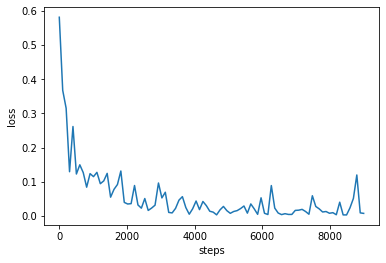


Update value of best Accuracy
Up Accuracy to 99.29 with structure:
Out struct = 	[16, 120, 280]	 kernel size = 	[3, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

Epoch [1/15], Step [100/600], Loss: 0.6808
Epoch [1/15], Step [200/600], Loss: 0.3758
Epoch [1/15], Step [300/600], Loss: 0.3919
Epoch [1/15], Step [400/600], Loss: 0.2165
Epoch [1/15], Step [500/600], Loss: 0.2503
Epoch [1/15], Step [600/600], Loss: 0.2633
Epoch [2/15], Step [100/600], Loss: 0.1542
Epoch [2/15], Step [200/600], Loss: 0.1881
Epoch [2/15], Step [300/600], Loss: 0.1234
Epoch [2/15], Step [400/600], Loss: 0.1158
Epoch [2/15], Step [500/600], Loss: 0.0762
Epoch [2/15], Step [600/600], Loss: 0.1421
Epoch [3/15], Step [100/600], Loss: 0.0712
Epoch [3/15], Step [200/600], Loss: 0.1366
Epoch [3/15], Step [300/600], Loss: 0.1432
Epoch [3/15], Step [400/600], Loss: 0.0489
Epoch [3/15], Step [500/600], Loss: 0.1297
Epoch [3/15], Step [600/600], Loss: 0.12

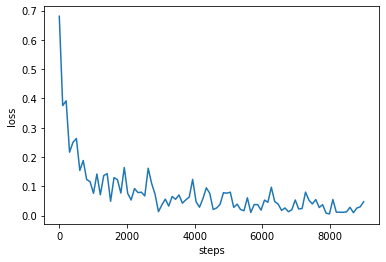



Epoch [1/15], Step [100/600], Loss: 0.3782
Epoch [1/15], Step [200/600], Loss: 0.3177
Epoch [1/15], Step [300/600], Loss: 0.3353
Epoch [1/15], Step [400/600], Loss: 0.1426
Epoch [1/15], Step [500/600], Loss: 0.0782
Epoch [1/15], Step [600/600], Loss: 0.1555
Epoch [2/15], Step [100/600], Loss: 0.0988
Epoch [2/15], Step [200/600], Loss: 0.0688
Epoch [2/15], Step [300/600], Loss: 0.0741
Epoch [2/15], Step [400/600], Loss: 0.0917
Epoch [2/15], Step [500/600], Loss: 0.0771
Epoch [2/15], Step [600/600], Loss: 0.0744
Epoch [3/15], Step [100/600], Loss: 0.0949
Epoch [3/15], Step [200/600], Loss: 0.0422
Epoch [3/15], Step [300/600], Loss: 0.0716
Epoch [3/15], Step [400/600], Loss: 0.1618
Epoch [3/15], Step [500/600], Loss: 0.0810
Epoch [3/15], Step [600/600], Loss: 0.0876
Epoch [4/15], Step [100/600], Loss: 0.0890
Epoch [4/15], Step [200/600], Loss: 0.0905
Epoch [4/15], Step [300/600], Loss: 0.0676
Epoch [4/15], Step [400/600], Loss: 0.1091
Epoch [4/15], Step [500/600], Loss: 0.0398
Epoch [4/

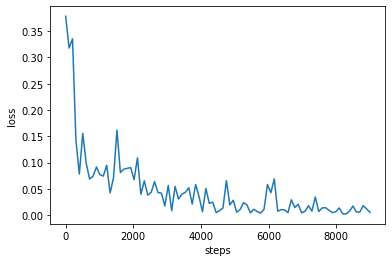



Epoch [1/15], Step [100/600], Loss: 0.5231
Epoch [1/15], Step [200/600], Loss: 0.3418
Epoch [1/15], Step [300/600], Loss: 0.4368
Epoch [1/15], Step [400/600], Loss: 0.2476
Epoch [1/15], Step [500/600], Loss: 0.2965
Epoch [1/15], Step [600/600], Loss: 0.2663
Epoch [2/15], Step [100/600], Loss: 0.1520
Epoch [2/15], Step [200/600], Loss: 0.2164
Epoch [2/15], Step [300/600], Loss: 0.2760
Epoch [2/15], Step [400/600], Loss: 0.2159
Epoch [2/15], Step [500/600], Loss: 0.2266
Epoch [2/15], Step [600/600], Loss: 0.2526
Epoch [3/15], Step [100/600], Loss: 0.3356
Epoch [3/15], Step [200/600], Loss: 0.1900
Epoch [3/15], Step [300/600], Loss: 0.1025
Epoch [3/15], Step [400/600], Loss: 0.1619
Epoch [3/15], Step [500/600], Loss: 0.2475
Epoch [3/15], Step [600/600], Loss: 0.1358
Epoch [4/15], Step [100/600], Loss: 0.0816
Epoch [4/15], Step [200/600], Loss: 0.1000
Epoch [4/15], Step [300/600], Loss: 0.1491
Epoch [4/15], Step [400/600], Loss: 0.1265
Epoch [4/15], Step [500/600], Loss: 0.0859
Epoch [4/

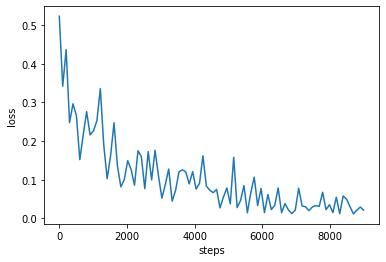



Epoch [1/15], Step [100/600], Loss: 0.2417
Epoch [1/15], Step [200/600], Loss: 0.0911
Epoch [1/15], Step [300/600], Loss: 0.1619
Epoch [1/15], Step [400/600], Loss: 0.0515
Epoch [1/15], Step [500/600], Loss: 0.0782
Epoch [1/15], Step [600/600], Loss: 0.0274
Epoch [2/15], Step [100/600], Loss: 0.0552
Epoch [2/15], Step [200/600], Loss: 0.0228
Epoch [2/15], Step [300/600], Loss: 0.0876
Epoch [2/15], Step [400/600], Loss: 0.0496
Epoch [2/15], Step [500/600], Loss: 0.0245
Epoch [2/15], Step [600/600], Loss: 0.0198
Epoch [3/15], Step [100/600], Loss: 0.0283
Epoch [3/15], Step [200/600], Loss: 0.0151
Epoch [3/15], Step [300/600], Loss: 0.0322
Epoch [3/15], Step [400/600], Loss: 0.0612
Epoch [3/15], Step [500/600], Loss: 0.0259
Epoch [3/15], Step [600/600], Loss: 0.0052
Epoch [4/15], Step [100/600], Loss: 0.0068
Epoch [4/15], Step [200/600], Loss: 0.0180
Epoch [4/15], Step [300/600], Loss: 0.0110
Epoch [4/15], Step [400/600], Loss: 0.0161
Epoch [4/15], Step [500/600], Loss: 0.0077
Epoch [4/

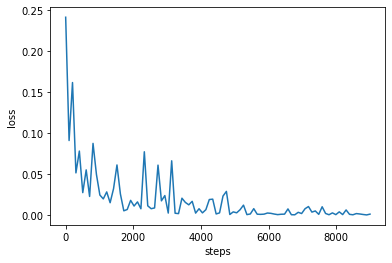


Update value of best Accuracy
Up Accuracy to 99.49 with structure:
Out struct = 	[160, 480, 860]	 kernel size = 	[5, 5, 4]
Stride value = 	[1, 1, 1]	 activation func = 	ReLU()
Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

Epoch [1/15], Step [100/600], Loss: 0.2949
Epoch [1/15], Step [200/600], Loss: 0.2336
Epoch [1/15], Step [300/600], Loss: 0.1120
Epoch [1/15], Step [400/600], Loss: 0.1411
Epoch [1/15], Step [500/600], Loss: 0.0600
Epoch [1/15], Step [600/600], Loss: 0.0434
Epoch [2/15], Step [100/600], Loss: 0.0868
Epoch [2/15], Step [200/600], Loss: 0.0354
Epoch [2/15], Step [300/600], Loss: 0.0468
Epoch [2/15], Step [400/600], Loss: 0.0440
Epoch [2/15], Step [500/600], Loss: 0.0306
Epoch [2/15], Step [600/600], Loss: 0.0440
Epoch [3/15], Step [100/600], Loss: 0.0287
Epoch [3/15], Step [200/600], Loss: 0.0190
Epoch [3/15], Step [300/600], Loss: 0.0610
Epoch [3/15], Step [400/600], Loss: 0.0407
Epoch [3/15], Step [500/600], Loss: 0.0168
Epoch [3/15], Step [600/600], Loss: 0.0

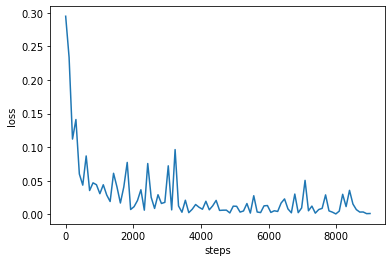



Epoch [1/15], Step [100/600], Loss: 0.1741
Epoch [1/15], Step [200/600], Loss: 0.1125
Epoch [1/15], Step [300/600], Loss: 0.1595
Epoch [1/15], Step [400/600], Loss: 0.0854
Epoch [1/15], Step [500/600], Loss: 0.0631
Epoch [1/15], Step [600/600], Loss: 0.0647
Epoch [2/15], Step [100/600], Loss: 0.0496
Epoch [2/15], Step [200/600], Loss: 0.0508
Epoch [2/15], Step [300/600], Loss: 0.1065
Epoch [2/15], Step [400/600], Loss: 0.0399
Epoch [2/15], Step [500/600], Loss: 0.0210
Epoch [2/15], Step [600/600], Loss: 0.0306
Epoch [3/15], Step [100/600], Loss: 0.0172
Epoch [3/15], Step [200/600], Loss: 0.0264
Epoch [3/15], Step [300/600], Loss: 0.0103
Epoch [3/15], Step [400/600], Loss: 0.0438
Epoch [3/15], Step [500/600], Loss: 0.0148
Epoch [3/15], Step [600/600], Loss: 0.0191
Epoch [4/15], Step [100/600], Loss: 0.0532
Epoch [4/15], Step [200/600], Loss: 0.0307
Epoch [4/15], Step [300/600], Loss: 0.0079
Epoch [4/15], Step [400/600], Loss: 0.0109
Epoch [4/15], Step [500/600], Loss: 0.0348
Epoch [4/

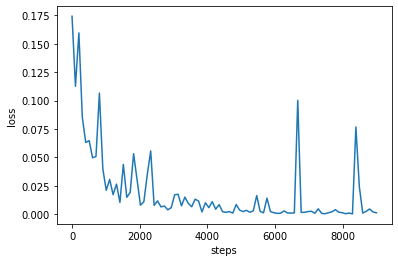



Epoch [1/15], Step [100/600], Loss: 0.2954
Epoch [1/15], Step [200/600], Loss: 0.3699
Epoch [1/15], Step [300/600], Loss: 0.2658
Epoch [1/15], Step [400/600], Loss: 0.1913
Epoch [1/15], Step [500/600], Loss: 0.1734
Epoch [1/15], Step [600/600], Loss: 0.2312
Epoch [2/15], Step [100/600], Loss: 0.0548
Epoch [2/15], Step [200/600], Loss: 0.1408
Epoch [2/15], Step [300/600], Loss: 0.1369
Epoch [2/15], Step [400/600], Loss: 0.1390
Epoch [2/15], Step [500/600], Loss: 0.0351
Epoch [2/15], Step [600/600], Loss: 0.0829
Epoch [3/15], Step [100/600], Loss: 0.0558
Epoch [3/15], Step [200/600], Loss: 0.1143
Epoch [3/15], Step [300/600], Loss: 0.0280
Epoch [3/15], Step [400/600], Loss: 0.1025
Epoch [3/15], Step [500/600], Loss: 0.1062
Epoch [3/15], Step [600/600], Loss: 0.0283
Epoch [4/15], Step [100/600], Loss: 0.0501
Epoch [4/15], Step [200/600], Loss: 0.0235
Epoch [4/15], Step [300/600], Loss: 0.0482
Epoch [4/15], Step [400/600], Loss: 0.0486
Epoch [4/15], Step [500/600], Loss: 0.0555
Epoch [4/

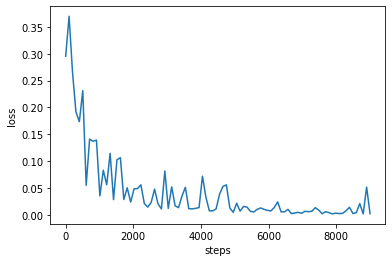



Epoch [1/15], Step [100/600], Loss: 0.2616
Epoch [1/15], Step [200/600], Loss: 0.1735
Epoch [1/15], Step [300/600], Loss: 0.0852
Epoch [1/15], Step [400/600], Loss: 0.0404
Epoch [1/15], Step [500/600], Loss: 0.0781
Epoch [1/15], Step [600/600], Loss: 0.0658
Epoch [2/15], Step [100/600], Loss: 0.0609
Epoch [2/15], Step [200/600], Loss: 0.0712
Epoch [2/15], Step [300/600], Loss: 0.0891
Epoch [2/15], Step [400/600], Loss: 0.0427
Epoch [2/15], Step [500/600], Loss: 0.0946
Epoch [2/15], Step [600/600], Loss: 0.0646
Epoch [3/15], Step [100/600], Loss: 0.0415
Epoch [3/15], Step [200/600], Loss: 0.0548
Epoch [3/15], Step [300/600], Loss: 0.0454
Epoch [3/15], Step [400/600], Loss: 0.0084
Epoch [3/15], Step [500/600], Loss: 0.0079
Epoch [3/15], Step [600/600], Loss: 0.0192
Epoch [4/15], Step [100/600], Loss: 0.0039
Epoch [4/15], Step [200/600], Loss: 0.0088
Epoch [4/15], Step [300/600], Loss: 0.0299
Epoch [4/15], Step [400/600], Loss: 0.0396
Epoch [4/15], Step [500/600], Loss: 0.0080
Epoch [4/

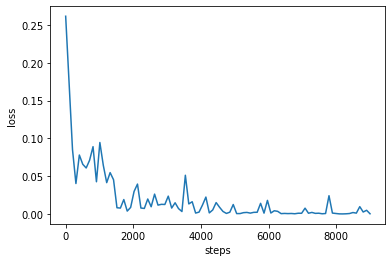



Epoch [1/15], Step [100/600], Loss: 0.2573
Epoch [1/15], Step [200/600], Loss: 0.2452
Epoch [1/15], Step [300/600], Loss: 0.1498
Epoch [1/15], Step [400/600], Loss: 0.0896
Epoch [1/15], Step [500/600], Loss: 0.1290
Epoch [1/15], Step [600/600], Loss: 0.1239
Epoch [2/15], Step [100/600], Loss: 0.0219
Epoch [2/15], Step [200/600], Loss: 0.0975
Epoch [2/15], Step [300/600], Loss: 0.0595
Epoch [2/15], Step [400/600], Loss: 0.0701
Epoch [2/15], Step [500/600], Loss: 0.0308
Epoch [2/15], Step [600/600], Loss: 0.0196
Epoch [3/15], Step [100/600], Loss: 0.0736
Epoch [3/15], Step [200/600], Loss: 0.0755
Epoch [3/15], Step [300/600], Loss: 0.0837
Epoch [3/15], Step [400/600], Loss: 0.0547
Epoch [3/15], Step [500/600], Loss: 0.0712
Epoch [3/15], Step [600/600], Loss: 0.0110
Epoch [4/15], Step [100/600], Loss: 0.0167
Epoch [4/15], Step [200/600], Loss: 0.0098
Epoch [4/15], Step [300/600], Loss: 0.0498
Epoch [4/15], Step [400/600], Loss: 0.0332
Epoch [4/15], Step [500/600], Loss: 0.0259
Epoch [4/

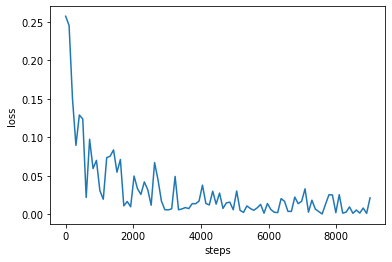



Epoch [1/15], Step [100/600], Loss: 0.2218
Epoch [1/15], Step [200/600], Loss: 0.1521
Epoch [1/15], Step [300/600], Loss: 0.1203
Epoch [1/15], Step [400/600], Loss: 0.0692
Epoch [1/15], Step [500/600], Loss: 0.0324
Epoch [1/15], Step [600/600], Loss: 0.1329
Epoch [2/15], Step [100/600], Loss: 0.0529
Epoch [2/15], Step [200/600], Loss: 0.0590
Epoch [2/15], Step [300/600], Loss: 0.0183
Epoch [2/15], Step [400/600], Loss: 0.0593
Epoch [2/15], Step [500/600], Loss: 0.0536
Epoch [2/15], Step [600/600], Loss: 0.0996
Epoch [3/15], Step [100/600], Loss: 0.0882
Epoch [3/15], Step [200/600], Loss: 0.0630
Epoch [3/15], Step [300/600], Loss: 0.0355
Epoch [3/15], Step [400/600], Loss: 0.0428
Epoch [3/15], Step [500/600], Loss: 0.0361
Epoch [3/15], Step [600/600], Loss: 0.0150
Epoch [4/15], Step [100/600], Loss: 0.0056
Epoch [4/15], Step [200/600], Loss: 0.0165
Epoch [4/15], Step [300/600], Loss: 0.0107
Epoch [4/15], Step [400/600], Loss: 0.0276
Epoch [4/15], Step [500/600], Loss: 0.0240
Epoch [4/

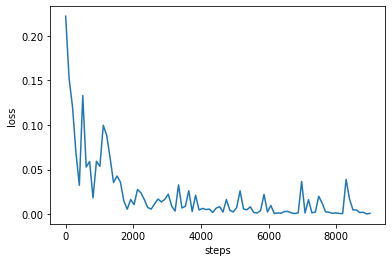



Epoch [1/15], Step [100/600], Loss: 0.3009
Epoch [1/15], Step [200/600], Loss: 0.2695
Epoch [1/15], Step [300/600], Loss: 0.2236
Epoch [1/15], Step [400/600], Loss: 0.1294
Epoch [1/15], Step [500/600], Loss: 0.2418
Epoch [1/15], Step [600/600], Loss: 0.1975
Epoch [2/15], Step [100/600], Loss: 0.1786
Epoch [2/15], Step [200/600], Loss: 0.1897
Epoch [2/15], Step [300/600], Loss: 0.1355
Epoch [2/15], Step [400/600], Loss: 0.1143
Epoch [2/15], Step [500/600], Loss: 0.2092
Epoch [2/15], Step [600/600], Loss: 0.0290
Epoch [3/15], Step [100/600], Loss: 0.0488
Epoch [3/15], Step [200/600], Loss: 0.1369
Epoch [3/15], Step [300/600], Loss: 0.1147
Epoch [3/15], Step [400/600], Loss: 0.1134
Epoch [3/15], Step [500/600], Loss: 0.0609
Epoch [3/15], Step [600/600], Loss: 0.0858
Epoch [4/15], Step [100/600], Loss: 0.0387
Epoch [4/15], Step [200/600], Loss: 0.0230
Epoch [4/15], Step [300/600], Loss: 0.0908
Epoch [4/15], Step [400/600], Loss: 0.0787
Epoch [4/15], Step [500/600], Loss: 0.0656
Epoch [4/

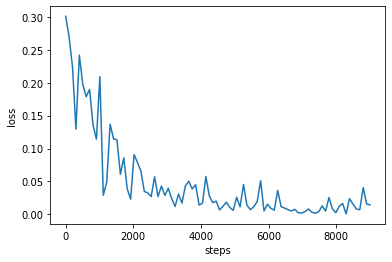

In [40]:
for o in out:
    for ks in kernel_size:
        for s in stride:
            for a in activation:
                for p in pool:
                    model = LeNet5(
                        n_classes=num_classes, out = o, kernel_size = ks, 
                        activation = a, stride = s, pool = p, 
                        kernel_size_pool = kernel_size_pool)
                    model.to(device)
                    train(model, num_epochs, True, True)
                    Accuracy_chek = Accuracy_value(model)
                    print()
                    if(Accuracy < Accuracy_chek):
                        Accuracy = Accuracy_chek
                        out_best.append(o)
                        kernel_best.append(ks)
                        stride_best.append(s)
                        activation_best.append(a)
                        pool_best.append(p)

                        print("Update value of best Accuracy")
                        print(f"Up Accuracy to {Accuracy} with structure:")
                        print(f"Out struct = \t{out_best[upd]}\t kernel size = \t{kernel_best[upd]}")
                        print(f"Stride value = \t{stride_best[upd]}\t activation func = \t{activation_best[upd]}")
                        print(f"Pool = {pool_best[upd]}") 
                        upd += 1
                    
                    print()

In [41]:
print("Update value of best Accuracy")
print(f"Up Accuracy to {Accuracy} with structure:")

Update value of best Accuracy
Up Accuracy to 99.49 with structure:


structure:

Out struct = 	[160, 480, 860]	 kernel size = 	[5, 5, 4]

Stride value = 	[1, 1, 1]	 activation func = 	ReLU()

Pool = <class 'torch.nn.modules.pooling.MaxPool2d'>

#### Задание 3 (факультативное).
Построить свёрточную сеть по одной из рассмотренных архитектур (AlexNet, VGG, Inception, ResNet) и обучить её распознаванию MNIST.

#### Задание 4 (факультативное).
Прочитать параграф 5.3 в учебнике С. Николенко и др. (стр. 199–206) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.